In [44]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"
)

import pyspark
from pyspark.sql import SparkSession
from App.utils import *
from graphframes import *

hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"

conf = pyspark.SparkConf().setAppName("Explore Entry Record").setMaster("local[*]")
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

resident_file_dest = "resident.parquet"
place_file_dest = "place.parquet"
safe_entry_file_dest = "entry_record.parquet"
contact_graph_edge_file_dest = "contact_graph_edge.parquet"
contact_graph_vertex_file_dest = "contact_graph_vertex.parquet"

communities_file_dest = "communities.parquet"

#### Step 1: Retrieve Graph Data

In [45]:
e = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_edge_file_dest)
v = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_vertex_file_dest)
g = GraphFrame(v, e)

g.edges.show()
g.vertices.show()


+--------+--------+
|     src|     dst|
+--------+--------+
| rid_290| rid_119|
| rid_119| rid_290|
|rid_1732|rid_1925|
|rid_1925|rid_1732|
| rid_580| rid_115|
| rid_115| rid_580|
|rid_1422| rid_127|
| rid_127|rid_1422|
|rid_1073|rid_1454|
|rid_1454|rid_1073|
| rid_233|rid_1413|
|rid_1413| rid_233|
|rid_1453| rid_254|
| rid_254|rid_1453|
| rid_277|  rid_53|
|  rid_53| rid_277|
| rid_238| rid_639|
| rid_639| rid_238|
| rid_844|rid_1025|
|rid_1025| rid_844|
+--------+--------+
only showing top 20 rows

+------+----------------+--------+------------+--------------------+
|    id|   resident_name|    nric|phone_number|      last_update_dt|
+------+----------------+--------+------------+--------------------+
| rid_1| resident_name_1|S000001U|    80000001|2021-04-13 23:22:...|
| rid_2| resident_name_2|S000002J|    80000002|2021-04-13 23:22:...|
| rid_3| resident_name_3|F000003Q|    80000003|2021-04-13 23:22:...|
| rid_4| resident_name_4|F000004E|    80000004|2021-04-13 23:22:...|
| rid_5| re

#### Step 2: visualize in NetworkX

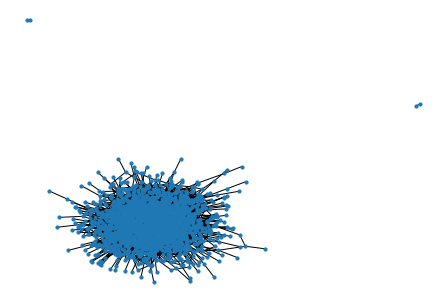

In [46]:
g_pdf = g.edges.select("*").toPandas()

import networkx as nx
import matplotlib.pyplot as plt
g_nx = nx.from_pandas_edgelist(g_pdf, source='src', target='dst')
nx.draw(g_nx,node_size = 10)
plt.show()

#### Step 3.1: Find Close Node

In [47]:
from pyspark.sql.functions import explode

confirmed_cases = ['rid_949']

shortest_path_df = g.shortestPaths(landmarks=confirmed_cases)
shortest_path_df.select("id", "distances").orderBy('id').show(20,False)

shortest_path_df=shortest_path_df.select("id", explode("distances"))

print(f"============close contact as below============")
shortest_path_df.filter(shortest_path_df.value == 1).show()

+--------+--------------+
|id      |distances     |
+--------+--------------+
|rid_1   |[rid_949 -> 7]|
|rid_10  |[rid_949 -> 6]|
|rid_100 |[rid_949 -> 6]|
|rid_1000|[rid_949 -> 6]|
|rid_1001|[rid_949 -> 7]|
|rid_1002|[rid_949 -> 6]|
|rid_1003|[rid_949 -> 8]|
|rid_1004|[rid_949 -> 7]|
|rid_1005|[rid_949 -> 6]|
|rid_1006|[rid_949 -> 6]|
|rid_1007|[rid_949 -> 6]|
|rid_1008|[rid_949 -> 5]|
|rid_1009|[rid_949 -> 8]|
|rid_101 |[rid_949 -> 7]|
|rid_1010|[rid_949 -> 5]|
|rid_1011|[rid_949 -> 6]|
|rid_1012|[rid_949 -> 6]|
|rid_1013|[rid_949 -> 6]|
|rid_1014|[rid_949 -> 6]|
|rid_1015|[rid_949 -> 6]|
+--------+--------------+
only showing top 20 rows

============close contact as below============
+--------+-------+-----+
|      id|    key|value|
+--------+-------+-----+
| rid_610|rid_949|    1|
|rid_1617|rid_949|    1|
+--------+-------+-----+



#### Step 3.2: Community Detection
##### Build model, can not use SCC and CC

In [48]:
communities_df = g.labelPropagation(maxIter=10)

from pyspark.sql import functions as func
communities_df.sort("label").groupby("label").agg(func.collect_list("id")).show()

communities_df.orderBy("label").show()

communities_hdfs_path = hdfs_host + hdfs_root_path + communities_file_dest
communities_df.write.mode("Overwrite").parquet(communities_hdfs_path)

+------------+--------------------+
|       label|    collect_list(id)|
+------------+--------------------+
| 51539607556|          [rid_1695]|
| 60129542148|           [rid_718]|
| 68719476740|[rid_1084, rid_70...|
| 77309411332|          [rid_1948]|
| 77309411333|           [rid_834]|
| 85899345923|[rid_1245, rid_1526]|
| 94489280519|           [rid_498]|
|103079215107|          [rid_1889]|
|103079215108|           [rid_267]|
|111669149698|          [rid_1789]|
|111669149702|           [rid_772]|
|137438953472|          [rid_1139]|
|146028888065|[rid_1152, rid_32...|
|171798691844|  [rid_196, rid_440]|
|171798691845|           [rid_596]|
|180388626437|          [rid_1973]|
|188978561027|           [rid_711]|
|197568495629|           [rid_823]|
|214748364800|[rid_1796, rid_1707]|
|240518168579|[rid_1440, rid_1553]|
+------------+--------------------+
only showing top 20 rows

+--------+------------------+--------+------------+--------------------+------------+
|      id|     resident_

##### Find Cluster for resident

In [49]:
resident_id = 'rid_1152'
label = communities_df.filter("id = '" + resident_id + "'" ).collect()[0]['label']

print('============Resident in the same cluster============')
communities_df.filter("label = '"+ str(label) +"'").show()

============Resident in the same cluster============
+--------+------------------+--------+------------+--------------------+------------+
|      id|     resident_name|    nric|phone_number|      last_update_dt|       label|
+--------+------------------+--------+------------+--------------------+------------+
|rid_1152|resident_name_1152|S001152V|    90001152|2021-04-13 23:22:...|146028888065|
| rid_323| resident_name_323|F000323G|    80000323|2021-04-13 23:22:...|146028888065|
| rid_948| resident_name_948|S000948D|    90000948|2021-04-13 23:22:...|146028888065|
+--------+------------------+--------+------------+--------------------+------------+

